# University of Mannheim
## Data Mining I -- Group Project
### Wine Quality Prediction
#### Team members:
* Anna-Lena Blinken
* Max Darmstadt
* Nicolas Hautschek
* Erik Penther
* Nicolas Fürhaupter

## Importing Libraries and Data

In [1]:
#from google.colab import drive
#drive.mount('/gdrive')
#%cd /gdrive

In [2]:
# Import libraries

# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

# Libraries for the preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Liraries for the model creation
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Libraries for the evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import itertools

# Libraries for the model adaption
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from imblearn.over_sampling import SMOTE 
from collections import Counter
from sklearn.inspection import permutation_importance
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from math import sqrt

In [3]:
# Import wine data

wine_data = pd.read_csv('../winequalityN.csv')
wine_data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## Visualize and Analyse Data

In [4]:
# Print wine data info

wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [5]:
# Analyse the data by its mean etc.

wine_data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


### Null Values

In [6]:
# Check data for null values

wine_data.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [7]:
# Check class distribution

wine_data.quality.value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

### Class Distribution

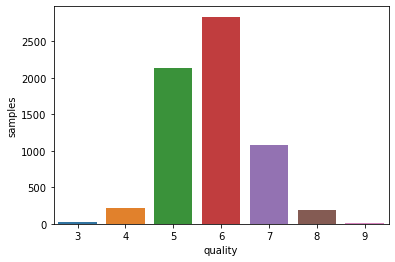

In [8]:
# Visualize class distribution

sns.barplot(x=wine_data.quality.value_counts().index, y=wine_data.quality.value_counts())
plt.ylabel('samples')
plt.xlabel('quality')
plt.show()

In [9]:
# Turn 10 classes into 3 classes

wine_data['quality'] = wine_data.quality.apply(lambda x: 2 if x>6 else (1 if x> 4 else 0))

In [10]:
# Check class distribution

wine_data.quality.value_counts()

1    4974
2    1277
0     246
Name: quality, dtype: int64

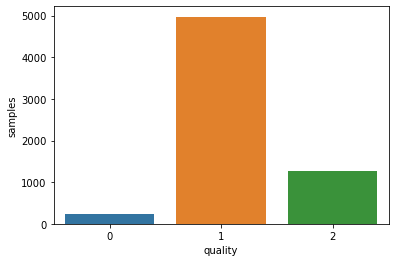

In [11]:
# Visualize class distribution

sns.barplot(x=wine_data.quality.value_counts().index, y=wine_data.quality.value_counts())
plt.ylabel('samples')
plt.xlabel('quality')
plt.show()

In [12]:
# Turn 10 classes into 2 classes

wine_data_2 = pd.read_csv('../winequalityN.csv')
wine_data_2['quality'] = wine_data_2.quality.apply(lambda x: 2 if x>5 else 0)

In [13]:
# Check class distribution

wine_data_2.quality.value_counts()

2    4113
0    2384
Name: quality, dtype: int64

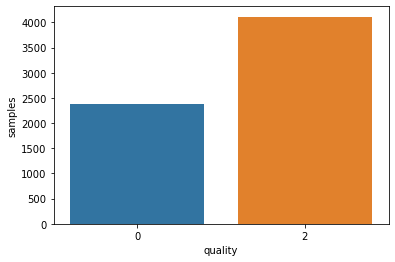

In [14]:
# Visualize class distribution

sns.barplot(x=wine_data_2.quality.value_counts().index, y=wine_data_2.quality.value_counts())
plt.ylabel('samples')
plt.xlabel('quality')
plt.show()

### Unique Values

In [15]:
# Count uniques values of each column

wine_data.nunique()

type                      2
fixed acidity           106
volatile acidity        187
citric acid              89
residual sugar          316
chlorides               214
free sulfur dioxide     135
total sulfur dioxide    276
density                 998
pH                      108
sulphates               111
alcohol                 111
quality                   3
dtype: int64

### Distribution of Values

<AxesSubplot:>

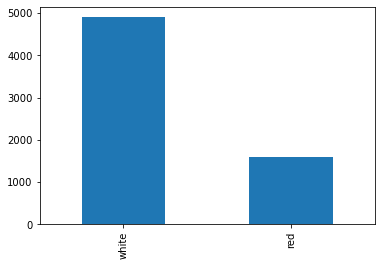

In [16]:
# Plot histogram for each categorical column

wine_data['type'].value_counts().plot(kind='bar')

array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>],
       [<AxesSubplot:title={'center':'residual sugar'}>,
        <AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}>],
       [<AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'pH'}>],
       [<AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'quality'}>]], dtype=object)

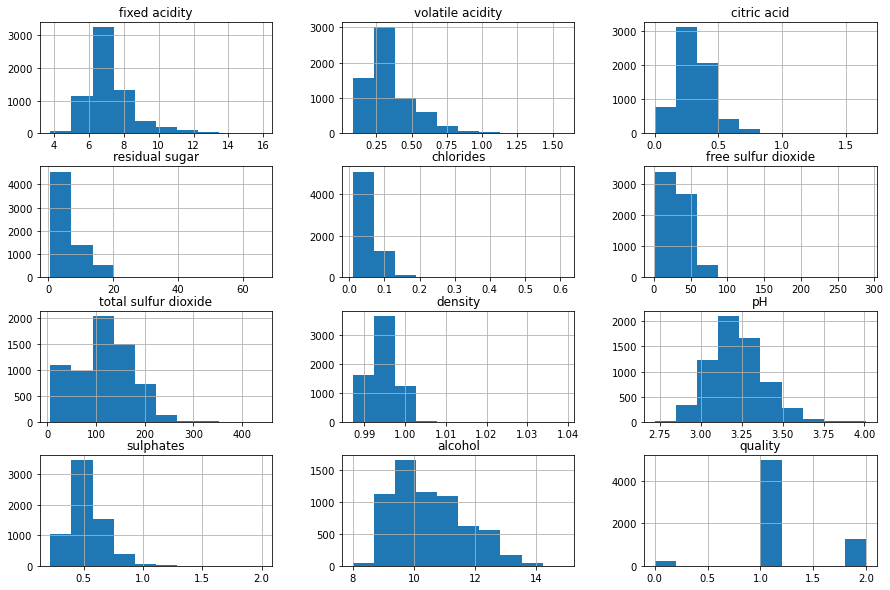

In [17]:
# Plot histogram for each numerical column

wine_data.hist(figsize=(15, 10))

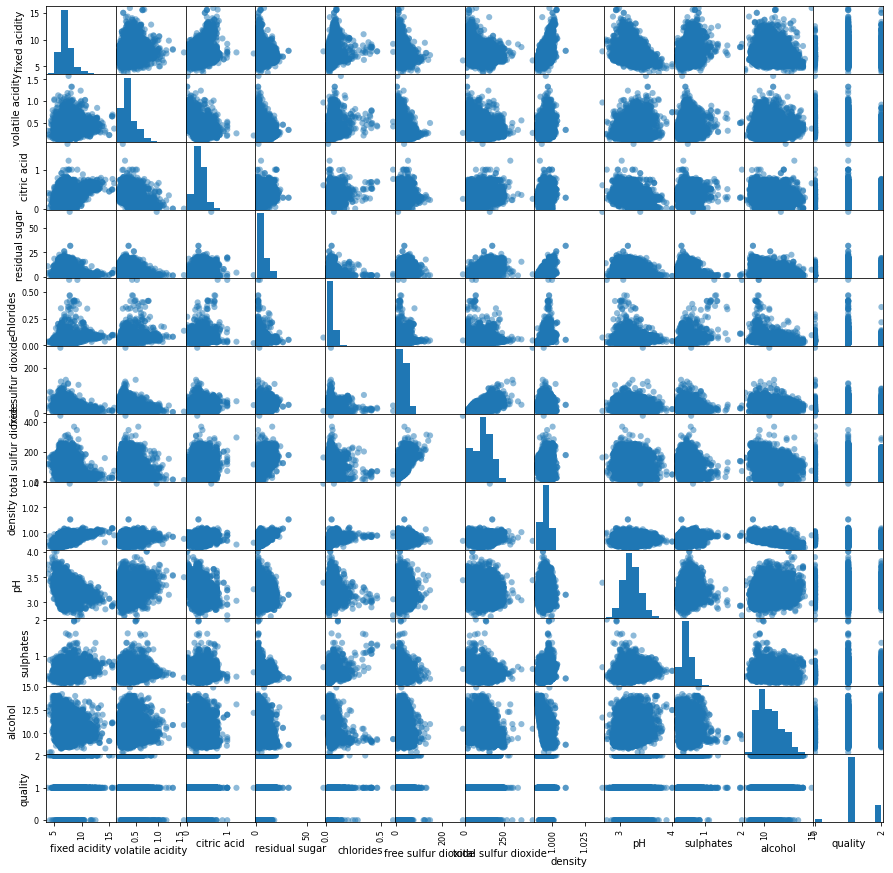

In [18]:
# Plot scatterplots for all possible combinations of columns

pd.plotting.scatter_matrix(wine_data, figsize=(15, 15), s=150);

## Data Cleaning

In [19]:
# Count duplicates and remove duplicates

display(len(wine_data.index))
wine_data.drop_duplicates()
display(len(wine_data.index))

6497

6497

In [20]:
# Ordinal Encoder for the attribute type

# Show data before preprocessing
display(wine_data.head())

# Create the OrdinalEncoder
ordinal_encoder = preprocessing.OrdinalEncoder()

# Preprocess the categorical feature type
wine_data[['type']] = ordinal_encoder.fit_transform(wine_data[['type']])

# Show the results
wine_data.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1.0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,1.0,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,1.0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,1.0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,1.0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


In [21]:
# Normalisation of the numerical values

# Show data before preprocessing
display(wine_data.head())

# Create the normaliser
scaler = preprocessing.MinMaxScaler()

# Preprocess the all numerical features
wine_data[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']] = scaler.fit_transform(wine_data[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']])

# Show the results
display(wine_data.head())

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1.0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,1.0,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,1.0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,1.0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,1.0,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1.0,0.264463,0.126667,0.216867,0.308282,0.059801,0.152778,0.377880,0.267785,0.217054,0.129213,0.115942,1
1,1.0,0.206612,0.146667,0.204819,0.015337,0.066445,0.045139,0.290323,0.132832,0.449612,0.151685,0.217391,1
2,1.0,0.355372,0.133333,0.240964,0.096626,0.068106,0.100694,0.209677,0.154039,0.418605,0.123596,0.304348,1
3,1.0,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362,1
4,1.0,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362,1


In [22]:
# Replacing null-values 

# Get column names
column_names = wine_data.columns

# Count null-values
display(wine_data.isnull().sum())
display(len(wine_data.index))

# Data imputation
imp = SimpleImputer(strategy="mean")
wine_data = imp.fit_transform(wine_data)

# Create dataframe from numpy array
wine_data = pd.DataFrame(data=wine_data, columns=column_names)
display(wine_data.isnull().sum())
display(len(wine_data.index))

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

6497

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

6497

### Seperation of features and the target variable and test train split

In [23]:
# Seperation of features and the target variable in two different data frames

wine_data = wine_data.copy()

features = wine_data.drop(columns='quality')
display(features.head())

target = wine_data.drop(columns=['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'])
target = target['quality'].ravel()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,1.0,0.264463,0.126667,0.216867,0.308282,0.059801,0.152778,0.377880,0.267785,0.217054,0.129213,0.115942
1,1.0,0.206612,0.146667,0.204819,0.015337,0.066445,0.045139,0.290323,0.132832,0.449612,0.151685,0.217391
2,1.0,0.355372,0.133333,0.240964,0.096626,0.068106,0.100694,0.209677,0.154039,0.418605,0.123596,0.304348
3,1.0,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362
4,1.0,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.163678,0.364341,0.101124,0.275362


In [24]:
# Train test split

data_train, data_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target)

## Random Forest

In [25]:
# Model Creation

# Create estimator and pipeline
random_forest = RandomForestClassifier(random_state=0)
pipeline_rf = Pipeline([('estimator', random_forest)])

# Fit the model and predict the values for the train data
pipeline_rf.fit(data_train, target_train)
predictions_train_rf = pipeline_rf.predict(data_train)

### Evaluation

In [26]:
# Predict values for the test data

predictions_test_rf = pipeline_rf.predict(data_test)

#### Makro F1-Score, Makro Precision, and Makro Recall

In [27]:
# Makro F1-Score
print("Makro F1-Score Train Data:")
f1_score_train_rf = f1_score(target_train, predictions_train_rf, average='macro')
display(f1_score_train_rf)

print("Makro F1-Score Test Data:")
f1_score_test_rf = f1_score(target_test, predictions_test_rf, average='macro')
display(f1_score_test_rf)

# Makro Precision Score
print("Makro Precision Train Data:")
precision_train_rf = precision_score(target_train, predictions_train_rf, average='macro', zero_division = 0)
display(precision_train_rf)

print("Makro Precision Test Data:")
precision_test_rf = precision_score(target_test, predictions_test_rf, average='macro', zero_division = 0)
display(precision_test_rf)

# Makro Recall Score
print("Makro Recall Train Data:")
recall_train_rf = recall_score(target_train, predictions_train_rf, average='macro')
display(recall_train_rf)

print("Makro Recall Test Data:")
recall_test_rf = recall_score(target_test, predictions_test_rf, average='macro')
display(recall_test_rf)

Makro F1-Score Train Data:


1.0

Makro F1-Score Test Data:


0.5956199538817564

Makro Precision Train Data:


1.0

Makro Precision Test Data:


0.8782390602944142

Makro Recall Train Data:


1.0

Makro Recall Test Data:


0.5524526330632755

#### Confusion Matrix

In [28]:
# Function to plot a confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion Matrix Train Data:


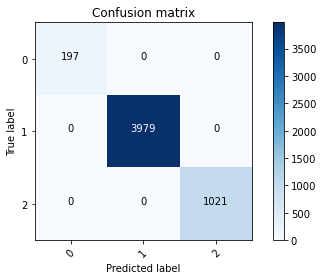

In [29]:
# Confusion Matrix for the training data

cnf_matrix_train_rf = confusion_matrix(target_train, predictions_train_rf)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
plot_confusion_matrix(cnf_matrix_train_rf, classes=np.array([0,1,2]))

Confusion Matrix Test Data:


None

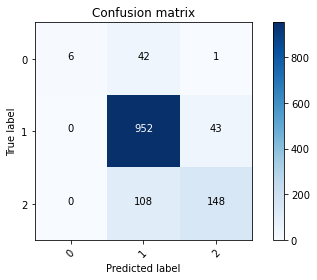

In [30]:
# Confusion Matrix for the test data

cnf_matrix_test_rf = confusion_matrix(target_test, predictions_test_rf)
np.set_printoptions(precision=2)
print("Confusion Matrix Test Data:")
display(plot_confusion_matrix(cnf_matrix_test_rf, classes=np.array([0,1,2])))

## Adoption of the Mode 
1. First Hyperparameter Tuning
2. Oversampling
3. Feature Selection
4. Second Hyperparameter Tuning

In each step the best model, which was achieved until that stage, is utilized.

### First Hyperparameter Tuning

In [31]:
# Create an estimator
random_forest = RandomForestClassifier()

# Specify the parameter grid
parameters = {
    #'max_depth': range(5, 14),
    #'n_estimators': [100, 300, 500, 700],
    'max_features': [None, sqrt, 0.3, 2],
    #'min_samples_leaf': [3, 4, 5],
    #'min_samples_split': [8, 10, 12],
    
}

# Specify the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create the grid search instance
grid_search_estimator = GridSearchCV(random_forest, parameters, scoring='f1_macro', cv=stratified_10_fold_cv, n_jobs = -1, verbose = 2, return_train_score=False)

# Run the grid search
grid_search_estimator.fit(data_train, target_train)

# Print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)
display(results)
    
# Print the best parameter setting
print("best score is {} with params {}".format(grid_search_estimator.best_score_, grid_search_estimator.best_params_))

Fitting 10 folds for each of 4 candidates, totalling 40 fits


/Users/I500970/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.57  nan 0.56 0.56]
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,3.441787,0.043319,0.040692,0.008268,None,{'max_features': None},0.565094,0.577515,0.558180,0.536058,0.582482,0.554142,0.534282,0.614504,0.611660,0.539264,0.567318,0.027648,1
1,0.084592,0.007035,0.000000,0.000000,<built-in function sqrt>,{'max_features': <built-in function sqrt>},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
2,1.171834,0.101503,0.029517,0.003385,0.3,{'max_features': 0.3},0.555339,0.560241,0.555915,0.543955,0.581525,0.549987,0.508713,0.601949,0.554252,0.542720,0.555460,0.023184,3
3,0.870183,0.133385,0.031327,0.005994,2,{'max_features': 2},0.545373,0.547334,0.559279,0.550132,0.600964,0.552085,0.539223,0.574183,0.551303,0.577366,0.559724,0.017951,2


best score is 0.5673183196332705 with params {'max_features': None}


#### Model with Hyperparameter Tuning
As a basis the model without the feature type is used, as this model creates the best outcome for both train and test data and reduces the difference between train and test data.

Makro F1-Score Train Data:


0.6661373227162263

Makro F1-Score Test Data:


0.4889295368077602

Makro Precision Train Data:


0.9615622800089367

Makro Precision Test Data:


0.5247889811562376

Makro Recall Train Data:


0.6216928513099437

Makro Recall Test Data:


0.47551298157453936

Confusion Matrix Train Data:


None

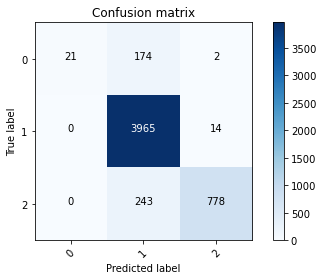

In [32]:
# Changing Hyperparameters

# Creation of the RandomForest and the pipeline
random_forest = RandomForestClassifier(random_state=0, max_depth = 13, n_estimators = 700, max_features=0.3, min_samples_leaf=3,
    min_samples_split=8)

pipeline_rf = Pipeline([('estimator', random_forest)])

# Fit the model and predict the values for the train data
pipeline_rf.fit(data_train, target_train)
predictions_train_rf = pipeline_rf.predict(data_train)

# Predict values for the test data
predictions_test_rf = pipeline_rf.predict(data_test)

# Makro F1-Score
print("Makro F1-Score Train Data:")
f1_score_train_rf = f1_score(target_train, predictions_train_rf, average='macro')
display(f1_score_train_rf)

print("Makro F1-Score Test Data:")
f1_score_test_rf = f1_score(target_test, predictions_test_rf, average='macro')
display(f1_score_test_rf)

# Makro Precision Score
print("Makro Precision Train Data:")
precision_train_rf = precision_score(target_train, predictions_train_rf, average='macro', zero_division = 0)
display(precision_train_rf)

print("Makro Precision Test Data:")
precision_test_rf = precision_score(target_test, predictions_test_rf, average='macro', zero_division = 0)
display(precision_test_rf)

# Makro Recall Score
print("Makro Recall Train Data:")
recall_train_rf = recall_score(target_train, predictions_train_rf, average='macro')
display(recall_train_rf)

print("Makro Recall Test Data:")
recall_test_rf = recall_score(target_test, predictions_test_rf, average='macro')
display(recall_test_rf)

# Confusion Matrix for the training data
cnf_matrix_train_rf = confusion_matrix(target_train, predictions_train_rf)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
display(plot_confusion_matrix(cnf_matrix_train_rf, classes=np.array([0,1,2])))

Confusion Matrix Train Data:


None

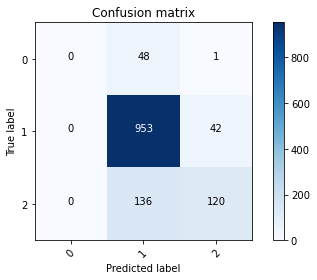

In [33]:
# Confusion Matrix for the test data

cnf_matrix_test_rf = confusion_matrix(target_test, predictions_test_rf)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
display(plot_confusion_matrix(cnf_matrix_test_rf, classes=np.array([0,1,2])))

### Oversampling
On the basis of the model with the hypertuning of the parameters.

Makro F1-Score Train Data:


0.9655337169257847

Makro F1-Score Test Data:


0.6106912566606539

Makro Precision Train Data:


0.9663980551087811

Makro Precision Test Data:


0.5788475219977814

Makro Recall Train Data:


0.9657367847867974

Makro Recall Test Data:


0.6746904430742147

Confusion Matrix Train Data:


None

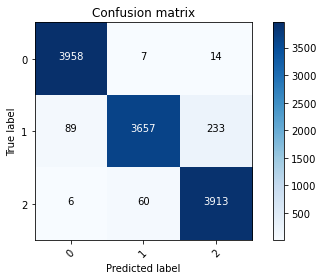

In [34]:
# Oversampling
data_train_smt = data_train.copy() 
target_train_smt = target_train.copy() 

smt = SMOTE(random_state=42)
data_train, target_train = smt.fit_resample(data_train_smt, target_train_smt)

# Create estimator and pipeline
random_forest = RandomForestClassifier(random_state=0, max_depth = 13, n_estimators = 700, max_features=0.3, min_samples_leaf=3,
    min_samples_split=8)
pipeline_rf = Pipeline([('estimator', random_forest)])

# Fit the model and predict the values for the train data
pipeline_rf.fit(data_train, target_train)
predictions_train_rf = pipeline_rf.predict(data_train)

# Predict values for the test data
predictions_test_rf = pipeline_rf.predict(data_test)

# Makro F1-Score
print("Makro F1-Score Train Data:")
f1_score_train_rf = f1_score(target_train, predictions_train_rf, average='macro')
display(f1_score_train_rf)

print("Makro F1-Score Test Data:")
f1_score_test_rf = f1_score(target_test, predictions_test_rf, average='macro')
display(f1_score_test_rf)

# Makro Precision Score
print("Makro Precision Train Data:")
precision_train_rf = precision_score(target_train, predictions_train_rf, average='macro', zero_division = 0)
display(precision_train_rf)

print("Makro Precision Test Data:")
precision_test_rf = precision_score(target_test, predictions_test_rf, average='macro', zero_division = 0)
display(precision_test_rf)

# Makro Recall Score
print("Makro Recall Train Data:")
recall_train_rf = recall_score(target_train, predictions_train_rf, average='macro')
display(recall_train_rf)

print("Makro Recall Test Data:")
recall_test_rf = recall_score(target_test, predictions_test_rf, average='macro')
display(recall_test_rf)

# Confusion Matrix for the training data
cnf_matrix_train_rf = confusion_matrix(target_train, predictions_train_rf)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
display(plot_confusion_matrix(cnf_matrix_train_rf, classes=np.array([0,1,2])))

Confusion Matrix Test Data:


None

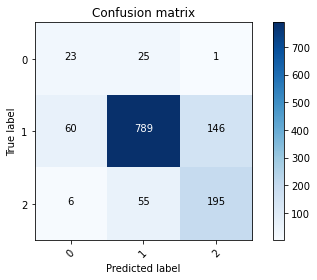

In [35]:
# Confusion Matrix for the test data

cnf_matrix_test_rf = confusion_matrix(target_test, predictions_test_rf)
np.set_printoptions(precision=2)
print("Confusion Matrix Test Data:")
display(plot_confusion_matrix(cnf_matrix_test_rf, classes=np.array([0,1,2])))

### Feature Selection
On the basis of the model with the hypertuning of the parameters and the oversampling.

[0.01 0.06 0.1  0.07 0.07 0.09 0.14 0.08 0.09 0.06 0.08 0.14]


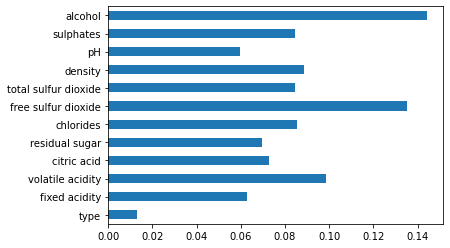

In [36]:
# Feature Importance

print(random_forest.feature_importances_) 
feat_importances = pd.Series(random_forest.feature_importances_, index=features.columns)
feat_importances.plot(kind='barh')
plt.show()

Text(0.5, 0, 'Permutation Importance')

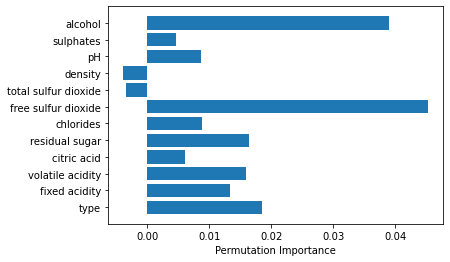

In [37]:
# Permutation Importance

perm_importance = permutation_importance(random_forest, data_test, target_test)
feature_list = list(features)
plt.barh(feature_list, perm_importance.importances_mean)
plt.xlabel("Permutation Importance")

In [38]:
# Feature correlation

wines = wine_data.copy()
y_ql = wines.drop(columns=['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'])

def VRF(predict, data, y):
   
    scale = StandardScaler(with_std=False)
    df = pd.DataFrame(scale.fit_transform(data), columns= cols)
    features = "+".join(cols)
    df['quality_label'] = y.values

    # Get y and X dataframes based on this regression:
    y, X = dmatrices(predict + ' ~' + features, data = df, return_type='dataframe')

    # Calculate VIF Factors: For each X, calculate VIF and save it in the dataframe
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    # Inspect VIF Factors
    display(vif.sort_values('VIF Factor'))
    return vif

cols = wines.columns.str.replace(' ', '_')
df = wines.copy()
df.columns = cols

vif = VRF('quality', df.loc[:, cols], y_ql)

,VIF Factor,features
0,1.000000,Intercept
13,1.239882,quality
11,1.569112,sulphates
4,1.620315,citric_acid
6,1.659194,chlorides
3,2.215939,volatile_acidity
7,2.243876,free_sulfur_dioxide
10,2.554538,pH
8,4.045689,total_sulfur_dioxide
2,5.034653,fixed_acidity


####  Feature Importance: Model without type

Makro F1-Score Train Data:


0.9664583784338382

Makro F1-Score Test Data:


0.5847776136183854

Makro Precision Train Data:


0.967318072724292

Makro Precision Test Data:


0.5579623428252601

Makro Recall Train Data:


0.9666582893524337

Makro Recall Test Data:


0.6438324167606742

Confusion Matrix Train Data:


None

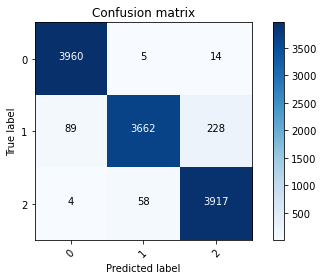

In [39]:
# Seperation of features and the target variable in two different data frames and dropping column type
features = wine_data.drop(columns=['quality', 'type'])
target = wine_data.drop(columns=['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'])
target = target['quality'].ravel()

# Train test split
data_train, data_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target)

# Oversampling
data_train_smt = data_train.copy() 
target_train_smt = target_train.copy() 

smt = SMOTE(random_state=42)
data_train, target_train = smt.fit_resample(data_train_smt, target_train_smt)

# Create estimator and pipeline
random_forest = RandomForestClassifier(random_state=0, max_depth = 13, n_estimators = 700, max_features=0.3, min_samples_leaf=3,
    min_samples_split=8)
pipeline_rf = Pipeline([('estimator', random_forest)])

# Fit the model and predict the values for the train data
pipeline_rf.fit(data_train, target_train)
predictions_train_rf = pipeline_rf.predict(data_train)

# Predict values for the test data
predictions_test_rf = pipeline_rf.predict(data_test)

# Makro F1-Score
print("Makro F1-Score Train Data:")
f1_score_train_rf = f1_score(target_train, predictions_train_rf, average='macro')
display(f1_score_train_rf)

print("Makro F1-Score Test Data:")
f1_score_test_rf = f1_score(target_test, predictions_test_rf, average='macro')
display(f1_score_test_rf)

# Makro Precision Score
print("Makro Precision Train Data:")
precision_train_rf = precision_score(target_train, predictions_train_rf, average='macro', zero_division = 0)
display(precision_train_rf)

print("Makro Precision Test Data:")
precision_test_rf = precision_score(target_test, predictions_test_rf, average='macro', zero_division = 0)
display(precision_test_rf)

# Makro Recall Score
print("Makro Recall Train Data:")
recall_train_rf = recall_score(target_train, predictions_train_rf, average='macro')
display(recall_train_rf)

print("Makro Recall Test Data:")
recall_test_rf = recall_score(target_test, predictions_test_rf, average='macro')
display(recall_test_rf)

# Confusion Matrix for the training data
cnf_matrix_train_rf = confusion_matrix(target_train, predictions_train_rf)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
display(plot_confusion_matrix(cnf_matrix_train_rf, classes=np.array([0,1,2])))

Confusion Matrix Test Data:


None

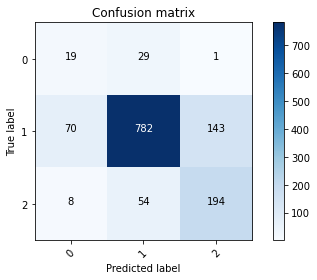

In [40]:
# Confusion Matrix for the test data

cnf_matrix_test_rf = confusion_matrix(target_test, predictions_test_rf)
np.set_printoptions(precision=2)
print("Confusion Matrix Test Data:")
display(plot_confusion_matrix(cnf_matrix_test_rf, classes=np.array([0,1,2])))

#### Feature Permutation: Model without sulphates, total sulfur dioxide, citric acid, and density 

,type,fixed acidity,volatile acidity,residual sugar,chlorides,free sulfur dioxide,pH,alcohol
0,1.0,0.264463,0.126667,0.308282,0.059801,0.152778,0.217054,0.115942
1,1.0,0.206612,0.146667,0.015337,0.066445,0.045139,0.449612,0.217391
2,1.0,0.355372,0.133333,0.096626,0.068106,0.100694,0.418605,0.304348
3,1.0,0.280992,0.100000,0.121166,0.081395,0.159722,0.364341,0.275362
4,1.0,0.280992,0.100000,0.121166,0.081395,0.159722,0.364341,0.275362


Makro F1-Score Train Data:


0.9523931543084524

Makro F1-Score Test Data:


0.5937101726068921

Makro Precision Train Data:


0.9535064980065456

Makro Precision Test Data:


0.5626290165912418

Makro Recall Train Data:


0.9526681745832285

Makro Recall Test Data:


0.6695894171110656

Confusion Matrix Train Data:


None

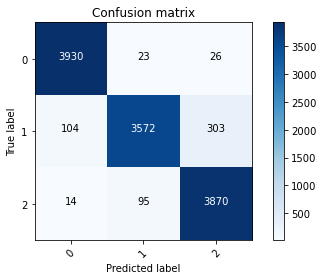

In [41]:
# Seperation of features and the target variable in two different data frames and dropping the columns quality, pH, and density
features = wine_data.drop(columns=['quality', 'sulphates', 'total sulfur dioxide', 'density', 'citric acid', ])
display(features.head())
target = wine_data.drop(columns=['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'])
target = target['quality'].ravel()

# Train test split
data_train, data_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target)

# Oversampling
data_train_smt = data_train.copy() 
target_train_smt = target_train.copy() 

smt = SMOTE(random_state=42)
data_train, target_train = smt.fit_resample(data_train_smt, target_train_smt)

# Create estimator and pipeline
random_forest = RandomForestClassifier(random_state=0, max_depth = 13, n_estimators = 700, max_features=0.3, min_samples_leaf=3,
    min_samples_split=8)
pipeline_rf = Pipeline([('estimator', random_forest)])

# Fit the model and predict the values for the train data
pipeline_rf.fit(data_train, target_train)
predictions_train_rf = pipeline_rf.predict(data_train)

# Predict values for the test data
predictions_test_rf = pipeline_rf.predict(data_test)

# Makro F1-Score
print("Makro F1-Score Train Data:")
f1_score_train_rf = f1_score(target_train, predictions_train_rf, average='macro')
display(f1_score_train_rf)

print("Makro F1-Score Test Data:")
f1_score_test_rf = f1_score(target_test, predictions_test_rf, average='macro')
display(f1_score_test_rf)

# Makro Precision Score
print("Makro Precision Train Data:")
precision_train_rf = precision_score(target_train, predictions_train_rf, average='macro', zero_division = 0)
display(precision_train_rf)

print("Makro Precision Test Data:")
precision_test_rf = precision_score(target_test, predictions_test_rf, average='macro', zero_division = 0)
display(precision_test_rf)

# Makro Recall Score
print("Makro Recall Train Data:")
recall_train_rf = recall_score(target_train, predictions_train_rf, average='macro')
display(recall_train_rf)

print("Makro Recall Test Data:")
recall_test_rf = recall_score(target_test, predictions_test_rf, average='macro')
display(recall_test_rf)

# Confusion Matrix for the training data
cnf_matrix_train_rf = confusion_matrix(target_train, predictions_train_rf)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
display(plot_confusion_matrix(cnf_matrix_train_rf, classes=np.array([0,1,2])))

Confusion Matrix Test Data:


None

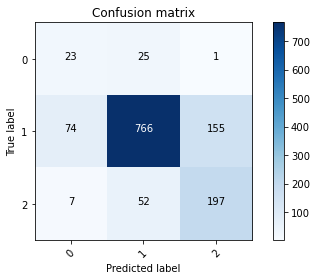

In [42]:
# Confusion Matrix for the test data

cnf_matrix_test_rf = confusion_matrix(target_test, predictions_test_rf)
np.set_printoptions(precision=2)
print("Confusion Matrix Test Data:")
display(plot_confusion_matrix(cnf_matrix_test_rf, classes=np.array([0,1,2])))

#### Feature Correlation: Model without fixed acidity, alcohol, type, residual sugar, and density

,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,pH,sulphates
0,0.126667,0.216867,0.059801,0.152778,0.377880,0.217054,0.129213
1,0.146667,0.204819,0.066445,0.045139,0.290323,0.449612,0.151685
2,0.133333,0.240964,0.068106,0.100694,0.209677,0.418605,0.123596
3,0.100000,0.192771,0.081395,0.159722,0.414747,0.364341,0.101124
4,0.100000,0.192771,0.081395,0.159722,0.414747,0.364341,0.101124


Makro F1-Score Train Data:


0.940501732975012

Makro F1-Score Test Data:


0.5599905114925142

Makro Precision Train Data:


0.942436753162155

Makro Precision Test Data:


0.5338284016821514

Makro Recall Train Data:


0.940939934656949

Makro Recall Test Data:


0.6300591232095853

Confusion Matrix Train Data:


None

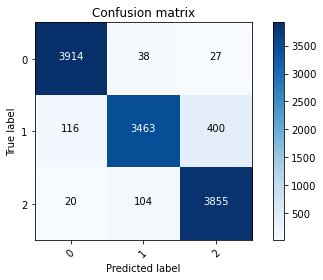

In [43]:
# Seperation of features and the target variable in two different data frames and dropping the columns fixed acidity, alcohol, type, residual sugar, and density
features = wine_data.drop(columns=['quality', 'type', 'fixed acidity', 'alcohol', 'density', 'residual sugar'])
display(features.head())
target = wine_data.drop(columns=['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'])
target = target['quality'].ravel()

# Train test split
data_train, data_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target)

# Oversampling
data_train_smt = data_train.copy() 
target_train_smt = target_train.copy() 

smt = SMOTE(random_state=42)
data_train, target_train = smt.fit_resample(data_train_smt, target_train_smt)

# Create estimator and pipeline
random_forest = RandomForestClassifier(random_state=0, max_depth = 13, n_estimators = 700, max_features=0.3, min_samples_leaf=3,
    min_samples_split=8)
pipeline_rf = Pipeline([('estimator', random_forest)])

# Fit the model and predict the values for the train data
pipeline_rf.fit(data_train, target_train)
predictions_train_rf = pipeline_rf.predict(data_train)

# Predict values for the test data
predictions_test_rf = pipeline_rf.predict(data_test)

# Makro F1-Score
print("Makro F1-Score Train Data:")
f1_score_train_rf = f1_score(target_train, predictions_train_rf, average='macro')
display(f1_score_train_rf)

print("Makro F1-Score Test Data:")
f1_score_test_rf = f1_score(target_test, predictions_test_rf, average='macro')
display(f1_score_test_rf)

# Makro Precision Score
print("Makro Precision Train Data:")
precision_train_rf = precision_score(target_train, predictions_train_rf, average='macro', zero_division = 0)
display(precision_train_rf)

print("Makro Precision Test Data:")
precision_test_rf = precision_score(target_test, predictions_test_rf, average='macro', zero_division = 0)
display(precision_test_rf)

# Makro Recall Score
print("Makro Recall Train Data:")
recall_train_rf = recall_score(target_train, predictions_train_rf, average='macro')
display(recall_train_rf)

print("Makro Recall Test Data:")
recall_test_rf = recall_score(target_test, predictions_test_rf, average='macro')
display(recall_test_rf)

# Confusion Matrix for the training data
cnf_matrix_train_rf = confusion_matrix(target_train, predictions_train_rf)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
display(plot_confusion_matrix(cnf_matrix_train_rf, classes=np.array([0,1,2])))

Confusion Matrix Test Data:


None

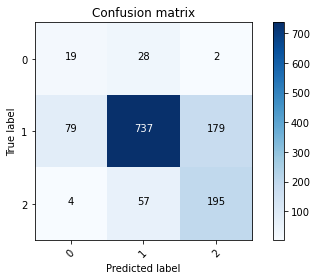

In [44]:
# Confusion Matrix for the test data

cnf_matrix_test_rf = confusion_matrix(target_test, predictions_test_rf)
np.set_printoptions(precision=2)
print("Confusion Matrix Test Data:")
display(plot_confusion_matrix(cnf_matrix_test_rf, classes=np.array([0,1,2])))

#### Feature Selection: Model without type, and density
Combining all models from above and therefore, only deleting columns, which are rated negatively by at least two of the three methods.

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,pH,sulphates,alcohol
0,0.264463,0.126667,0.216867,0.308282,0.059801,0.152778,0.377880,0.217054,0.129213,0.115942
1,0.206612,0.146667,0.204819,0.015337,0.066445,0.045139,0.290323,0.449612,0.151685,0.217391
2,0.355372,0.133333,0.240964,0.096626,0.068106,0.100694,0.209677,0.418605,0.123596,0.304348
3,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.364341,0.101124,0.275362
4,0.280992,0.100000,0.192771,0.121166,0.081395,0.159722,0.414747,0.364341,0.101124,0.275362


Makro F1-Score Train Data:


0.9638242894567085

Makro F1-Score Test Data:


0.6036666362497017

Makro Precision Train Data:


0.9648476141564695

Makro Precision Test Data:


0.5730939554131288

Makro Recall Train Data:


0.964061321940186

Makro Recall Test Data:


0.6659156219020271

Confusion Matrix Train Data:


None

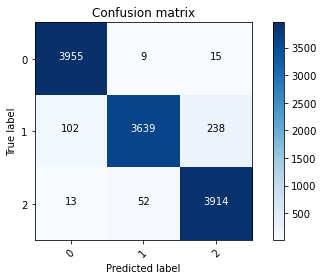

In [45]:
# Seperation of features and the target variable in two different data frames and dropping the columns fixed acidity, alcohol, type, residual sugar, and density
features = wine_data.drop(columns=['quality', 'density', 'type'])
display(features.head())
target = wine_data.drop(columns=['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'])
target = target['quality'].ravel()

# Train test split
data_train, data_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target)

# Oversampling
data_train_smt = data_train.copy() 
target_train_smt = target_train.copy() 

smt = SMOTE(random_state=42)
data_train, target_train = smt.fit_resample(data_train_smt, target_train_smt)

# Create estimator and pipeline
random_forest = RandomForestClassifier(random_state=0, max_depth = 13, n_estimators = 700, max_features=0.3, min_samples_leaf=3,
    min_samples_split=8)
pipeline_rf = Pipeline([('estimator', random_forest)])

# Fit the model and predict the values for the train data
pipeline_rf.fit(data_train, target_train)
predictions_train_rf = pipeline_rf.predict(data_train)

# Predict values for the test data
predictions_test_rf = pipeline_rf.predict(data_test)

# Makro F1-Score
print("Makro F1-Score Train Data:")
f1_score_train_rf = f1_score(target_train, predictions_train_rf, average='macro')
display(f1_score_train_rf)

print("Makro F1-Score Test Data:")
f1_score_test_rf = f1_score(target_test, predictions_test_rf, average='macro')
display(f1_score_test_rf)

# Makro Precision Score
print("Makro Precision Train Data:")
precision_train_rf = precision_score(target_train, predictions_train_rf, average='macro', zero_division = 0)
display(precision_train_rf)

print("Makro Precision Test Data:")
precision_test_rf = precision_score(target_test, predictions_test_rf, average='macro', zero_division = 0)
display(precision_test_rf)

# Makro Recall Score
print("Makro Recall Train Data:")
recall_train_rf = recall_score(target_train, predictions_train_rf, average='macro')
display(recall_train_rf)

print("Makro Recall Test Data:")
recall_test_rf = recall_score(target_test, predictions_test_rf, average='macro')
display(recall_test_rf)

# Confusion Matrix for the training data
cnf_matrix_train_rf = confusion_matrix(target_train, predictions_train_rf)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
display(plot_confusion_matrix(cnf_matrix_train_rf, classes=np.array([0,1,2])))

Confusion Matrix Test Data:


None

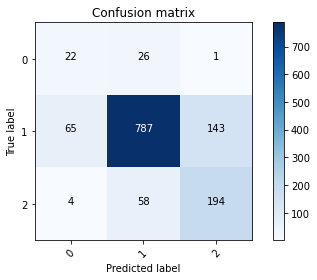

In [46]:
# Confusion Matrix for the test data

cnf_matrix_test_rf = confusion_matrix(target_test, predictions_test_rf)
np.set_printoptions(precision=2)
print("Confusion Matrix Test Data:")
display(plot_confusion_matrix(cnf_matrix_test_rf, classes=np.array([0,1,2])))

### Second Hyperparameter Tuning

In [47]:
# Seperation of features and the target variable in two different data frames
features = wine_data.drop(columns=['quality'])
target = wine_data.drop(columns=['type', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'])
target = target['quality'].ravel()

# Train test split
data_train, data_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42, stratify=target)

# Oversampling
data_train_smt = data_train.copy() 
target_train_smt = target_train.copy() 

smt = SMOTE(random_state=42)
data_train, target_train = smt.fit_resample(data_train_smt, target_train_smt)

# Create an estimator
random_forest = RandomForestClassifier()

# Specify the parameter grid
parameters = {
    #'max_depth': range(5, 14),
    #'n_estimators': [100, 300, 500, 700],
    #'max_features': [None, sqrt, 0.3, 2],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    
}

# Specify the cross validation
stratified_10_fold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create the grid search instance
grid_search_estimator = GridSearchCV(random_forest, parameters, scoring='f1_macro', cv=stratified_10_fold_cv, n_jobs = -1, verbose = 2, return_train_score=False)

# Run the grid search
grid_search_estimator.fit(data_train, target_train)

# Print the results of all hyper-parameter combinations
results = pd.DataFrame(grid_search_estimator.cv_results_)
display(results)
    
# Print the best parameter setting
print("best score is {} with params {}".format(grid_search_estimator.best_score_, grid_search_estimator.best_params_))

Fitting 10 folds for each of 9 candidates, totalling 90 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,2.699239,0.017335,0.050858,0.003839,3,8,"{'min_samples_leaf': 3, 'min_samples_split': 8}",0.917693,0.912083,0.930020,0.909544,0.897073,0.909553,0.912896,0.913067,0.909181,0.914547,0.912566,0.007779,1
1,2.793141,0.062712,0.051819,0.010018,3,10,"{'min_samples_leaf': 3, 'min_samples_split': 10}",0.906827,0.909722,0.926782,0.907124,0.900534,0.908049,0.904388,0.903885,0.900654,0.905814,0.907378,0.007060,2
2,2.975839,0.136651,0.046822,0.005202,3,12,"{'min_samples_leaf': 3, 'min_samples_split': 12}",0.906820,0.909682,0.917509,0.902782,0.897380,0.905289,0.901181,0.899363,0.902552,0.901226,0.904378,0.005545,4
3,3.080245,0.027650,0.048905,0.005618,4,8,"{'min_samples_leaf': 4, 'min_samples_split': 8}",0.906060,0.907741,0.920193,0.906228,0.897134,0.904339,0.903763,0.902922,0.901632,0.908473,0.905849,0.005704,3
4,3.082027,0.040507,0.047122,0.002393,4,10,"{'min_samples_leaf': 4, 'min_samples_split': 10}",0.907532,0.902030,0.922717,0.909629,0.893787,0.902780,0.903473,0.896863,0.891503,0.901685,0.903200,0.008429,5
5,3.004789,0.016647,0.043967,0.002188,4,12,"{'min_samples_leaf': 4, 'min_samples_split': 12}",0.908673,0.908818,0.914305,0.901283,0.899784,0.900998,0.892457,0.893322,0.894748,0.896579,0.901097,0.006993,6
6,2.958306,0.019926,0.048061,0.003337,5,8,"{'min_samples_leaf': 5, 'min_samples_split': 8}",0.904172,0.906976,0.909937,0.892435,0.887025,0.897604,0.892280,0.895865,0.887768,0.901759,0.897582,0.007531,8
7,2.937677,0.022932,0.045877,0.002043,5,10,"{'min_samples_leaf': 5, 'min_samples_split': 10}",0.903544,0.906835,0.914075,0.899544,0.895513,0.900112,0.894918,0.898123,0.887252,0.903299,0.900321,0.006924,7
8,2.355209,0.469023,0.035357,0.007361,5,12,"{'min_samples_leaf': 5, 'min_samples_split': 12}",0.897731,0.901060,0.914052,0.895959,0.888528,0.902831,0.892473,0.887506,0.884002,0.894062,0.895821,0.008300,9


best score is 0.9125655578002231 with params {'min_samples_leaf': 3, 'min_samples_split': 8}


#### Model with Hyperparameter Tuning

Makro F1-Score Train Data:


0.965104878055809

Makro F1-Score Test Data:


0.6071734643606517

Makro Precision Train Data:


0.965998554154198

Makro Precision Test Data:


0.5767794437164236

Makro Recall Train Data:


0.9653179190751445

Makro Recall Test Data:


0.6666235888199501

Confusion Matrix Train Data:


None

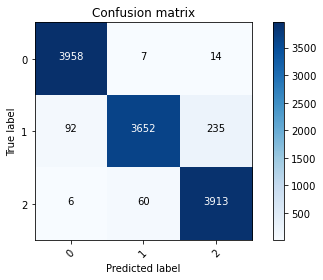

In [48]:
# Changing hyperparameters 

# Create estimator and pipeline
random_forest = RandomForestClassifier(random_state=0, max_depth = 13, n_estimators = 500, max_features=0.3, min_samples_leaf=3,
    min_samples_split=8)
pipeline_rf = Pipeline([('estimator', random_forest)])

# Fit the model and predict the values for the train data
pipeline_rf.fit(data_train, target_train)
predictions_train_rf = pipeline_rf.predict(data_train)

# Predict values for the test data
predictions_test_rf = pipeline_rf.predict(data_test)

# Makro F1-Score
print("Makro F1-Score Train Data:")
f1_score_train_rf = f1_score(target_train, predictions_train_rf, average='macro')
display(f1_score_train_rf)

print("Makro F1-Score Test Data:")
f1_score_test_rf = f1_score(target_test, predictions_test_rf, average='macro')
display(f1_score_test_rf)

# Makro Precision Score
print("Makro Precision Train Data:")
precision_train_rf = precision_score(target_train, predictions_train_rf, average='macro', zero_division = 0)
display(precision_train_rf)

print("Makro Precision Test Data:")
precision_test_rf = precision_score(target_test, predictions_test_rf, average='macro', zero_division = 0)
display(precision_test_rf)

# Makro Recall Score
print("Makro Recall Train Data:")
recall_train_rf = recall_score(target_train, predictions_train_rf, average='macro')
display(recall_train_rf)

print("Makro Recall Test Data:")
recall_test_rf = recall_score(target_test, predictions_test_rf, average='macro')
display(recall_test_rf)

# Confusion Matrix for the training data
cnf_matrix_train_rf = confusion_matrix(target_train, predictions_train_rf)
np.set_printoptions(precision=2)
print("Confusion Matrix Train Data:")
display(plot_confusion_matrix(cnf_matrix_train_rf, classes=np.array([0,1,2])))

Confusion Matrix Test Data:


None

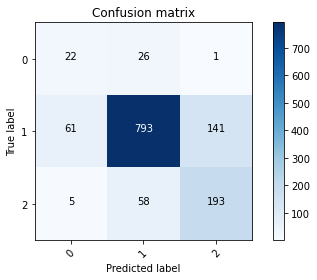

In [49]:
# Confusion Matrix for the test data

cnf_matrix_test_rf = confusion_matrix(target_test, predictions_test_rf)
np.set_printoptions(precision=2)
print("Confusion Matrix Test Data:")
display(plot_confusion_matrix(cnf_matrix_test_rf, classes=np.array([0,1,2])))